# Jimmy Liang
SJSU 001869817
### CMPE 258 - HW3 - Part C1 - Tensorflow without auto differenciation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

# Helper Classes

In [2]:
# 3D plot function

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  from sklearn.manifold import TSNE

  tsne = TSNE(n_components=2, random_state=0)
  x_2d = tsne.fit_transform(x)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x_2d[:, 0], x_2d[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x_2d[:, 0], x_2d[:, 1], y_pred, label='our function')
  plt.legend()

In [3]:
# Linear class

class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = tf.Variable(tf.random.uniform(shape=(input_dim, num_hidden)))
    self.bias = tf.Variable(tf.zeros(shape=(num_hidden,)))

  def __call__(self, x):
    self.x = x
    output = tf.matmul(x, self.weights) + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = tf.matmul(self.x,gradient,transpose_a=True)
    self.bias_gradient = tf.reduce_sum(gradient, 0)
    self.x_gradient = tf.matmul(gradient, self.weights, transpose_b=True)
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient


In [4]:
# MSE

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return tf.reduce_mean((y_pred - y_true) ** 2)

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient


In [5]:
# Relu function

class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = tf.clip_by_value(self.input_, 0, math.inf)
        return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = tf.cast((self.input_ > 0), tf.float32) * output_gradient
      return self.input_gradient

relu = Relu()

In [6]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 2)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2
  
  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

In [7]:
# Fit function
from typing import Callable
def fit(x , y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    if epoch % 5 == 0:
      print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

# Running the neural network

x: (100, 3), weights1: (3, 1), bias1: (1,),   weights2: (3, 1), bias2: (1,), y1: (100, 1),   y2: (100, 1),y: (100, 2)


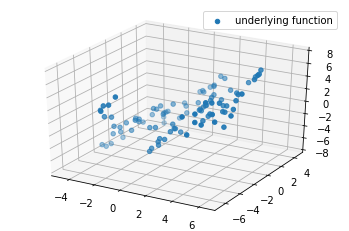

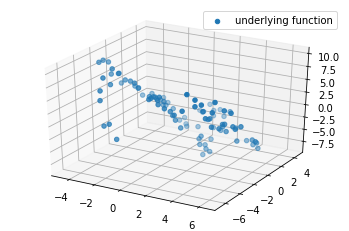

In [11]:
# 3 dimentional inputs, generating 2 non-linear outputs. 
# Generate some sample data

n = 100
d = 3
x = np.random.uniform(-1, 1, (n, d))
input_dim = d
output_dim = 2
learning_rate = 0.05 

weights1_true = np.array([[5, -1, 3], ]).T
weights2_true = np.array([[1, 8, -3], ]).T
bias1_true = np.array([0.5])
bias2_true = np.array([1])

y1_true = x @ weights1_true + bias1_true
y2_true = x @ weights2_true + bias2_true
y_true = np.hstack((y1_true, y2_true))

x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
y_tf = tf.convert_to_tensor(y_true, dtype=tf.float32)
print(f'x: {x.shape}, weights1: {weights1_true.shape}, bias1: {bias1_true.shape}, \
  weights2: {weights2_true.shape}, bias2: {bias2_true.shape}, y1: {y1_true.shape}, \
  y2: {y2_true.shape},y: {y_true.shape}')

plot_3d(x, y_true[:,0])
plot_3d(x, y_true[:,1])

Loss Value:  tf.Tensor(14.726004, shape=(), dtype=float32)


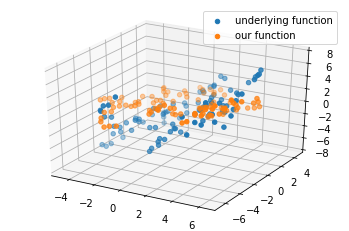

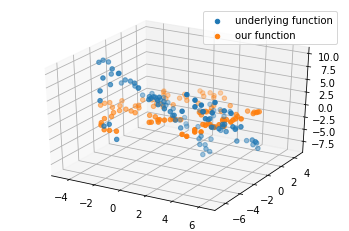

In [12]:
# Running the model

loss = MSE()
model = Model(d, 10)
y_pred = model(x_tf)
loss_value = loss(y_pred, y_tf)
loss_gradient = loss.backward()
print('Loss Value: ', loss_value)
model.backward(loss_gradient)
plot_3d(x, y_tf[:,0], y_pred[:,0])
plot_3d(x, y_tf[:,1], y_pred[:,1])

Epoch 0, loss 14.726003646850586
Epoch 5, loss 11.768637657165527
Epoch 10, loss 7.552875995635986
Epoch 15, loss 3.200988531112671
Epoch 20, loss 1.6636176109313965
Epoch 25, loss 1.2339608669281006
Epoch 30, loss 0.9797458648681641
Epoch 35, loss 0.7887217998504639


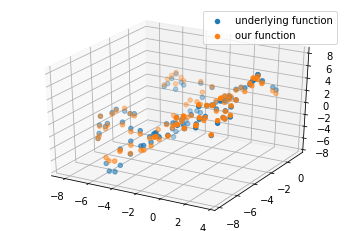

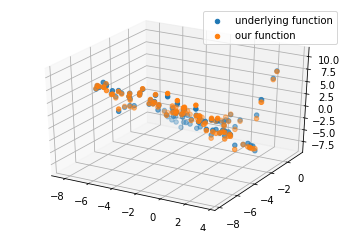

In [13]:
# Running the fit function, over 40 epochs

fit(x_tf, y_tf, model=model, loss=loss, lr=learning_rate, num_epochs=40)
y_pred = model(x_tf)
plot_3d(x_tf, y_tf[:,0], y_pred[:,0])
plot_3d(x_tf, y_tf[:,1], y_pred[:,1])